In [1]:
# coding: utf-8
import logging
import os

import geopandas as gpd
import numpy as np
import pandas as pd
import powerplantmatching as pm
import pypsa
import xarray as xr
#from _helpers import configure_logging, getContinent, update_p_nom_max, pdbcast
from shapely.validation import make_valid
from shapely.geometry import Point
from vresutils import transfer as vtransfer

idx = pd.IndexSlice

In [2]:
import yaml
with open("../config.yaml", 'r') as stream:
    try:
        snakemake_config=yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [119]:
base_n= pypsa.Network('../networks/base_9-supply_LC.nc')

INFO:pypsa.io:Imported network base_9-supply_LC.nc has buses, lines


In [134]:
n= pypsa.Network('../results/version-0.6/networks/solved_ambitions_9-supply_redz_lcopt_LC.nc')
n.snpashots = n.snapshots.get_level_values(1)

INFO:pypsa.io:Imported network solved_ambitions_9-supply_redz_lcopt_LC.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [128]:
n.generators[n.generators.carrier=='coal']

,carrier,p_nom,build_year,y,x,efficiency,marginal_cost,capital_cost,ramp_limit_up,lifetime,...,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
Duvha,coal,2875.0,2025,-25.95954,29.34094,0.326264,187.210989,5.940000e+05,0.068870,9.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Grootvlei,coal,570.0,2025,-26.76955,28.49951,0.285488,335.690237,5.940000e+05,0.094737,3.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Hendrina,coal,1098.0,2025,-26.03138,29.60138,0.296760,263.236980,5.940000e+05,0.060109,1.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Kendal,coal,3840.0,2025,-26.08805,28.96888,0.306305,275.615805,5.940000e+05,0.028125,18.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Komati,coal,114.0,2025,-26.09078,29.47446,0.260323,300.401200,5.940000e+05,0.263158,3.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Kriel,coal,2850.0,2025,-26.25404,29.18008,0.320199,266.129916,5.940000e+05,0.075789,4.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Kusile,coal,2880.0,2025,-25.54590,28.55020,0.366898,239.945366,4.700000e+06,0.150000,26.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Lethabo,coal,3558.0,2025,-26.74027,27.97500,0.328018,179.929512,5.940000e+05,0.099494,15.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaDry,coal,1833.0,2025,-27.09555,29.77055,0.306305,313.225137,5.940000e+05,0.055646,23.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0


In [143]:
n.generators_t.p_max_pu

Generator                   Ankerlig    Duvha  EASTERN CAPE CCGT_2025  \
period timestep                                                         
2025   2025-01-01 00:00:00   0.97802  0.40358                 0.97802   
       2025-01-01 01:00:00   0.97802  0.40358                 0.97802   
       2025-01-01 02:00:00   0.97802  0.40358                 0.97802   
       2025-01-01 03:00:00   0.97802  0.40358                 0.97802   
       2025-01-01 04:00:00   0.97802  0.40358                 0.97802   
...                              ...      ...                     ...   
       2025-12-31 19:00:00   0.98466  0.38556                 0.98466   
       2025-12-31 20:00:00   0.98466  0.38556                 0.98466   
       2025-12-31 21:00:00   0.98466  0.38556                 0.98466   
       2025-12-31 22:00:00   0.98466  0.38556                 0.98466   
       2025-12-31 23:00:00   0.98466  0.38556                 0.98466   

Generator                   EASTERN CAPE OCGT_2025  EASTERN CAPE nuclear_2025  \
period timestep                                                                 
2025   2025-01-01 00:00:00                 0.97802                   0.921932   
       2025-01-01 01:00:00                 0.97802                   0.921932   
       2025-01-01 02:00:00                 0.97802                   0.921932   
       2025-01-01 03:00:00                 0.97802                   0.921932   
       2025-01-01 04:00:00                 0.97802                   0.921932   
...                                            ...                        ...   
       2025-12-31 19:00:00                 0.98466                   0.874126   
       2025-12-31 20:00:00                 0.98466                   0.874126   
       2025-12-31 21:00:00                 0.98466                   0.874126   
       2025-12-31 22:00:00                 0.98466                   0.874126   
       2025-12-31 23:00:00                 0.98466                   0.874126   

Generator                   GAUTENG CCGT_2025  GAUTENG OCGT_2025  \
period timestep                                                    
2025   2025-01-01 00:00:00            0.97802            0.97802   
       2025-01-01 01:00:00            0.97802            0.97802   
       2025-01-01 02:00:00            0.97802            0.97802   
       2025-01-01 03:00:00            0.97802            0.97802   
       2025-01-01 04:00:00            0.97802            0.97802   
...                                       ...                ...   
       2025-12-31 19:00:00            0.98466            0.98466   
       2025-12-31 20:00:00            0.98466            0.98466   
       2025-12-31 21:00:00            0.98466            0.98466   
       2025-12-31 22:00:00            0.98466            0.98466   
       2025-12-31 23:00:00            0.98466            0.98466   

Generator                   GAUTENG coal_2025  Gourikwa  Grootvlei  ...  \
period timestep                                                     ...   
2025   2025-01-01 00:00:00                0.5   0.97458    0.57890  ...   
       2025-01-01 01:00:00                0.5   0.97458    0.57890  ...   
       2025-01-01 02:00:00                0.5   0.97458    0.57890  ...   
       2025-01-01 03:00:00                0.5   0.97458    0.57890  ...   
       2025-01-01 04:00:00                0.5   0.97458    0.57890  ...   
...                                       ...       ...        ...  ...   
       2025-12-31 19:00:00                0.5   0.98784    0.50698  ...   
       2025-12-31 20:00:00                0.5   0.98784    0.50698  ...   
       2025-12-31 21:00:00                0.5   0.98784    0.50698  ...   
       2025-12-31 22:00:00                0.5   0.98784    0.50698  ...   
       2025-12-31 23:00:00                0.5   0.98784    0.50698  ...   

Generator                   MajubaWet  Matimba    Matla   Medupi  \
period timestep                                                    

In [145]:
n.generators[n.generators.carrier=='OCGT'].index

Index(['GAUTENG OCGT_2025', 'WESTERN CAPE OCGT_2025', 'KZN OCGT_2025',
       'EASTERN CAPE OCGT_2025'],
      dtype='object', name='Generator')

<AxesSubplot:xlabel='period,timestep'>

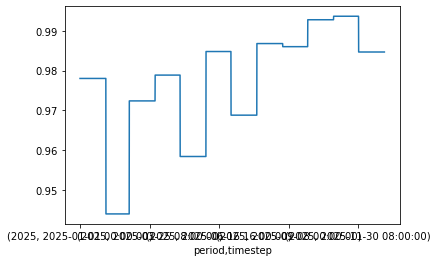

In [147]:

n.generators_t.p.index=n.snpashots
n.generators_t.p_max_pu[n.generators[n.generators.carrier=='CCGT'].index].mean(axis=1).plot()
#n.generators_t.p_min_pu[n.generators[n.generators.carrier=='coal'].index].mean(axis=1).plot()

In [136]:
n.generators.p_nom_opt.groupby(n.generators.carrier).sum()

carrier
CCGT             2.100673e-04
OCGT             2.220967e-04
coal             3.663500e+04
gas              4.250000e+02
load_shedding    9.000000e+06
nuclear          1.854000e+03
oil              3.072000e+03
onwind           7.892462e-04
solar            3.862171e+04
Name: p_nom_opt, dtype: float64

<AxesSubplot:xlabel='timestep'>

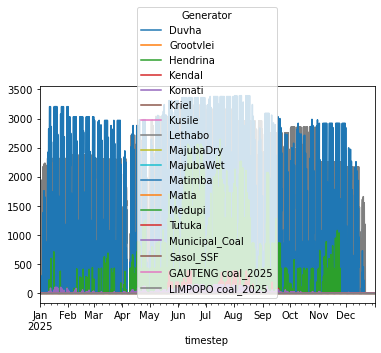

In [133]:
n.generators_t.p[n.generators[n.generators.carrier=='coal'].index].plot()

In [5]:
eskom_data = pd.read_excel('../data/Eskom EAF data.xlsx',sheet_name='eskom_data',index_col=[1,0],parse_dates=True)

In [11]:
eskom_data.index.get_level_values(0).unique()

Index(['Acacia', 'Ankerlig', 'Arnot', 'Camden', 'Drakensberg', 'Duvha',
       'Gariep', 'Generation Total', 'Gourikwa', 'Grootvlei', 'Hendrina',
       'Ingula', 'Kendal', 'Koeberg', 'Komati', 'Kriel', 'Kusile', 'Lethabo',
       'MajubaWet', 'MajubaDry', 'Matimba', 'Matla', 'Medupi', 'Palmiet',
       'Port Rex', 'Tutuka', 'Vanderkloof', 'coal_total', 'ocgt_total',
       'hydro_total', 'nuclear_total', 'phs_total', 'non_coal_total',
       'non_coal_nuclear_total'],
      dtype='object', name='station')

In [14]:
n.generators.index[n.generators.index.isin(eskom_data.index.get_level_values(0).unique())]

Index(['Duvha', 'Grootvlei', 'Hendrina', 'Kendal', 'Komati', 'Kriel',
       'Lethabo', 'MajubaDry', 'MajubaWet', 'Matimba', 'Matla', 'Medupi',
       'Tutuka'],
      dtype='object', name='Generator')

In [22]:
n.generators[n.generators.carrier=='coal']

,carrier,p_nom,build_year,y,x,efficiency,marginal_cost,capital_cost,ramp_limit_up,lifetime,...,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
Duvha,coal,2900.0,2025,-25.95954,29.34094,0.326264,187.211894,5.940000e+05,0.068276,9.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Grootvlei,coal,1080.0,2025,-26.76955,28.49951,0.285488,335.691518,5.940000e+05,0.050000,3.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Hendrina,coal,1900.0,2025,-26.03138,29.60138,0.296760,263.237988,5.940000e+05,0.034737,1.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Kendal,coal,3840.0,2025,-26.08805,28.96888,0.306305,275.616771,5.940000e+05,0.028125,18.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Komati,coal,900.0,2025,-26.09078,29.47446,0.260323,300.400808,5.940000e+05,0.033333,3.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Kriel,coal,2880.0,2025,-26.25404,29.18008,0.320199,266.129816,5.940000e+05,0.075000,4.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Lethabo,coal,3540.0,2025,-26.74027,27.97500,0.328018,179.929642,5.940000e+05,0.100000,15.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaDry,coal,1830.0,2025,-27.09555,29.77055,0.306305,313.226246,5.940000e+05,0.055738,23.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaWet,coal,2010.0,2025,-27.09555,29.77055,0.327154,313.403232,5.940000e+05,0.056716,26.0,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0


In [49]:
y_ref = [2017,2018,2019]
snapshots = n.snapshots.get_level_values(1)
eaf_profiles = pd.DataFrame(1,index=snapshots,columns=n.generators.index)
delta_eaf=1
for tech in n.generators.index[n.generators.index.isin(eskom_data.index.get_level_values(0).unique())]:
    reference_data = eskom_data.loc[tech].loc[eskom_data.loc[tech].index.year.isin(y_ref)]
    base_eaf=(reference_data['EAF %']/100).groupby(reference_data['EAF %'].index.month).mean()
    for y in n.investment_periods:
        eaf_profiles.loc[str(y),tech]=base_eaf[eaf_profiles.loc[str(y)].index.month].values
eaf_profiles.index=n.snapshots

for additional_coal in n.generators[(n.generators.carrier=='coal') & (~n.generators.index.isin(eskom_data.index.get_level_values(0).unique()))].index:
    eaf_profiles[additional_coal] = eaf_profiles['Lethabo']

for additional_ocgt in n.generators[(n.generators.carrier=='OCGT') & (~n.generators.index.isin(eskom_data.index.get_level_values(0).unique()))].index:
    eaf_profiles[additional_coal] = eaf_profiles['Ankerlig']

for additional_ccgt in n.generators[(n.generators.carrier=='CCGT') & (~n.generators.index.isin(eskom_data.index.get_level_values(0).unique()))].index:
    eaf_profiles[additional_ccgt] = eaf_profiles['Ankerlig']

for additional_nuclear in n.generators[(n.generators.carrier=='CCGT') & (~n.generators.index.isin(eskom_data.index.get_level_values(0).unique()))].index:
    eaf_profiles[additional_nuclear] = eaf_profiles['Koeberg']


n.import_series_from_dataframe(eaf_profiles,
                    "Generator",
                    "p_max_pu")

In [107]:
eskom_data.index.get_level_values(0).unique()

Index(['Acacia', 'Ankerlig', 'Arnot', 'Camden', 'Drakensberg', 'Duvha',
       'Gariep', 'Generation Total', 'Gourikwa', 'Grootvlei', 'Hendrina',
       'Ingula', 'Kendal', 'Koeberg', 'Komati', 'Kriel', 'Kusile', 'Lethabo',
       'MajubaWet', 'MajubaDry', 'Matimba', 'Matla', 'Medupi', 'Palmiet',
       'Port Rex', 'Tutuka', 'Vanderkloof', 'coal_total', 'ocgt_total',
       'hydro_total', 'nuclear_total', 'phs_total', 'non_coal_total',
       'non_coal_nuclear_total'],
      dtype='object', name='station')

In [105]:
for additional_coal in n.generators[(n.generators.carrier=='coal') & (~n.generators.index.isin(eskom_data.index.get_level_values(0).unique()))].index:
    eaf_profiles[additional_coal] = eaf_profiles['Lethabo']

for additional_ocgt in n.generators[(n.generators.carrier=='OCGT') & (~n.generators.index.isin(eskom_data.index.get_level_values(0).unique()))].index:
    eaf_profiles[additional_coal] = eaf_profiles['Ankerlig']

for additional_ccgt in n.generators[(n.generators.carrier=='CCGT') & (~n.generators.index.isin(eskom_data.index.get_level_values(0).unique()))].index:
    eaf_profiles[additional_ccgt] = eaf_profiles['Ankerlig']

for additional_nuclear in n.generators[(n.generators.carrier=='CCGT') & (~n.generators.index.isin(eskom_data.index.get_level_values(0).unique()))].index:
    eaf_profiles[additional_nuclear] = eaf_profiles['Koeberg']

KeyError: 'Ankerlig'

In [104]:
n.generators.carrier.unique()

array(['coal', 'nuclear', 'onwind', 'solar', 'CCGT', 'OCGT',
       'load_shedding'], dtype=object)

In [92]:
y_ref = [2017,2018,2019]
snapshots = n.snapshots.get_level_values(1)
eaf_profiles = pd.DataFrame(1,index=snapshots,columns=n.generators.index)
delta_eaf=1
for tech in n.generators.index[n.generators.index.isin(eskom_data.index.get_level_values(0).unique())]:
    reference_data = eskom_data.loc[tech].loc[eskom_data.loc[tech].index.year.isin(y_ref)]
    base_eaf=(reference_data['EAF %']/100).groupby(reference_data['EAF %'].index.month).mean()
    for y in n.investment_periods:
        eaf_profiles.loc[str(y),tech]=base_eaf[eaf_profiles.loc[str(y)].index.month].values
eaf_profiles.index=n.snapshots
n.import_series_from_dataframe(eaf_profiles,
                    "Generator",
                    "p_max_pu")

<AxesSubplot:xlabel='timestep'>

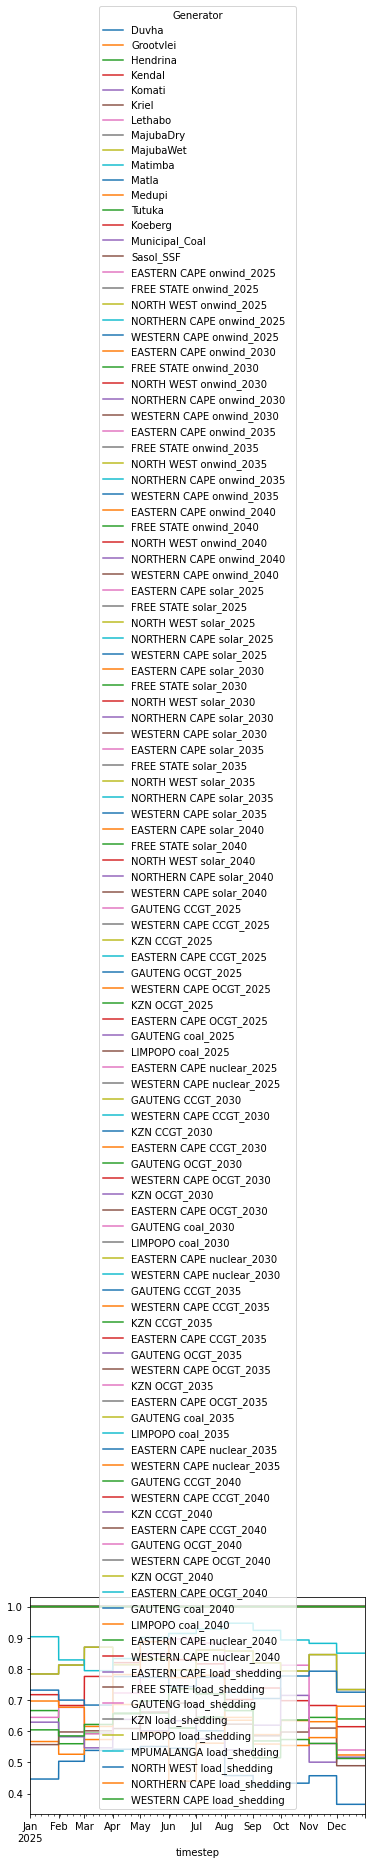

In [93]:
eaf_profiles.loc[2025].plot()

In [71]:
n.import_series_from_dataframe(eaf_profiles,
                    "Generator",
                    "p_max_pu")

<AxesSubplot:xlabel='period,timestep'>

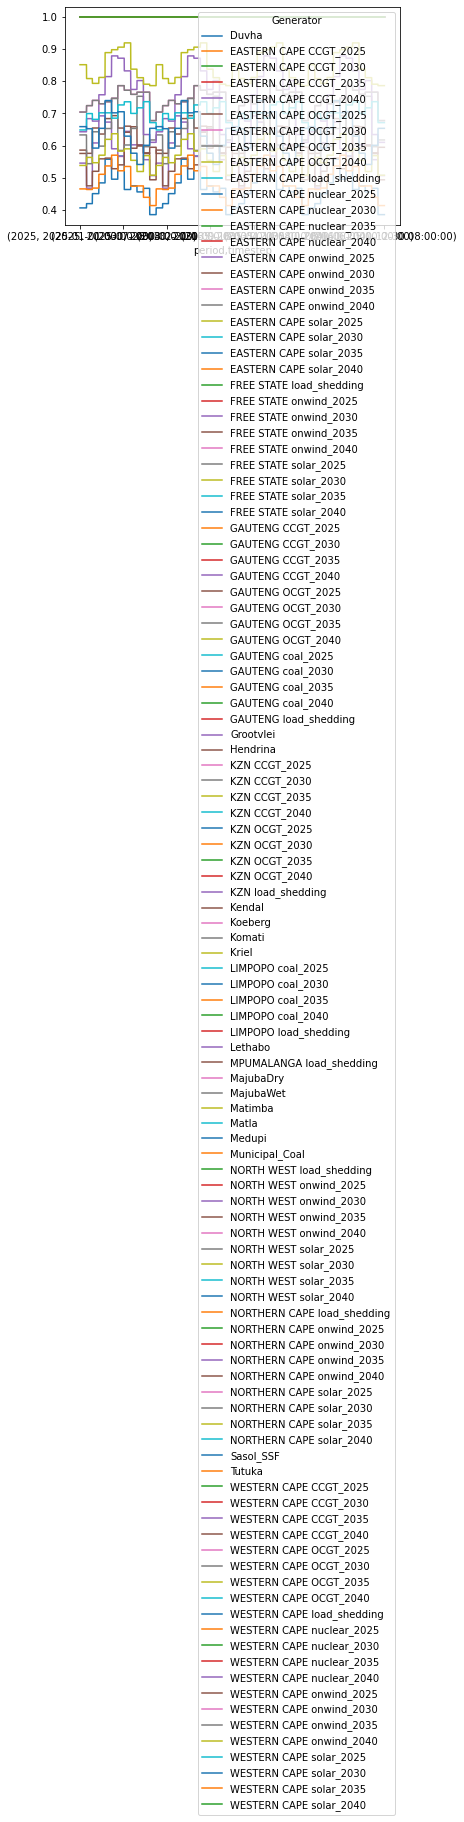

In [76]:
n.generators_t.p_max_pu.loc[2plot()

In [43]:
snapshots[snapshots.year==2025]

DatetimeIndex(['2025-01-01 00:00:00', '2025-01-01 01:00:00',
               '2025-01-01 02:00:00', '2025-01-01 03:00:00',
               '2025-01-01 04:00:00', '2025-01-01 05:00:00',
               '2025-01-01 06:00:00', '2025-01-01 07:00:00',
               '2025-01-01 08:00:00', '2025-01-01 09:00:00',
               ...
               '2025-12-31 14:00:00', '2025-12-31 15:00:00',
               '2025-12-31 16:00:00', '2025-12-31 17:00:00',
               '2025-12-31 18:00:00', '2025-12-31 19:00:00',
               '2025-12-31 20:00:00', '2025-12-31 21:00:00',
               '2025-12-31 22:00:00', '2025-12-31 23:00:00'],
              dtype='datetime64[ns]', name='timestep', length=8760, freq=None)

In [ ]:
n.generators.p_nom_opt.groupby(n.generators.carrier).sum()

carrier
CCGT       1.234523e+04
OCGT       5.321261e+03
coal       2.334900e+04
load       2.700000e+07
nuclear    1.860000e+03
onwind     5.294692e+04
solar      3.213143e+04
Name: p_nom_opt, dtype: float64

In [ ]:
n.storage_units.p_nom_opt.groupby(n.storage_units.carrier).sum()

carrier
PHS        2912.00000
battery    8622.68256
hydro      2165.00000
Name: p_nom_opt, dtype: float64

<AxesSubplot:xlabel='snapshot'>

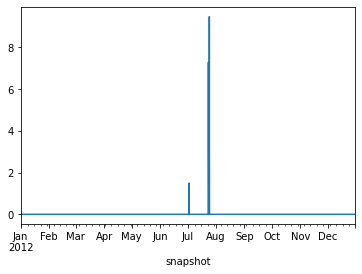

In [ ]:
n.generators_t.p['KAROO load'].plot()

In [ ]:
n.storage_units.capital_cost

StorageUnit
Drakensberg      2.010000e+05
Ingula           2.530000e+06
Palmiet          2.010000e+05
Gariep           0.000000e+00
Vanderkloof      0.000000e+00
ColleyWobbles    0.000000e+00
Steenbras        0.000000e+00
CahoraBassa      0.000000e+00
RSA battery      1.522227e+06
Name: capital_cost, dtype: float64

In [ ]:
n.generators.loc['RSA coal',:]

Owner                                
carrier                          coal
p_nom                             0.0
y                                 NaN
x                                 NaN
efficiency                      0.464
marginal_cost              376.747027
capital_cost            2094704.43397
ramp_limit_up                     NaN
bus                               RSA
p_nom_extendable                 True
p_nom_max                         inf
control                            PQ
sign                              1.0
p_nom_opt                         0.0
type                                 
p_nom_min                         0.0
p_min_pu                          0.0
p_max_pu                          1.0
p_set                             0.0
q_set                             0.0
build_year                          0
lifetime                          inf
committable                     False
start_up_cost                     0.0
shut_down_cost                    0.0
min_up_time 

In [ ]:
n= pypsa.Network('../results/version-0.5/networks/csir-aggressive_redz_E_LC_27-supply.nc')

INFO:pypsa.io:Imported network csir-aggressive_redz_E_LC_27-supply.nc has buses, carriers, generators, lines, loads, storage_units


In [ ]:
n.generators.loc['JOHANNESBURG Load']

,Owner,carrier,p_nom,y,x,efficiency,marginal_cost,capital_cost,ramp_limit_up,bus,...,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
Kendal,Eskom,Coal,3840.0,-26.08805,28.96888,0.306305,2.756163e+02,594000.0,0.028125,HIGHVELD NORTH,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Lethabo,Eskom,Coal,3540.0,-26.74027,27.97500,0.328018,1.799293e+02,594000.0,0.100000,VAAL TRIANGLE,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaDry,Eskom,Coal,1830.0,-27.09555,29.77055,0.306305,3.132249e+02,594000.0,0.055738,NEWCASTLE,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaWet,Eskom,Coal,2010.0,-27.09555,29.77055,0.327154,3.134030e+02,594000.0,0.056716,NEWCASTLE,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Matimba,Eskom,Coal,3720.0,-23.66777,27.61277,0.308907,1.898651e+02,594000.0,0.048387,WATERBERG,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HIGHVELD SOUTH Load,,load,1000000.0,NaN,NaN,1.000000,1.563000e+06,0.0,NaN,HIGHVELD SOUTH,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
HIGHVELD NORTH Load,,load,1000000.0,NaN,NaN,1.000000,1.563000e+06,0.0,NaN,HIGHVELD NORTH,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
LOWVELD Load,,load,1000000.0,NaN,NaN,1.000000,1.563000e+06,0.0,NaN,LOWVELD,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0


In [ ]:
n.storage_units.efficiency_dispatch

StorageUnit
Drakensberg      0.858487
Ingula           0.883176
Palmiet          0.882610
Gariep           1.000000
Vanderkloof      1.000000
ColleyWobbles    1.000000
Steenbras        0.848528
CahoraBassa      1.000000
RSA battery      0.943398
Name: efficiency_dispatch, dtype: float64